<a href="https://colab.research.google.com/github/hailuu684/Convolution-net/blob/main/HungarianLoss%2BBCELoss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
print(np.__version__)
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import csv

!pip install tensorflow_addons
import tensorflow_addons as tfa
from tensorflow.keras.layers import Dense, Concatenate, Input, Lambda

1.19.5
     |████████████████████████████████| 1.1 MB 4.9 MB/s 


In [ ]:
!pip install keras-metrics

In [ ]:
import keras_metrics as km

# Preprocess Hungarian Loss

In [ ]:
def replacenan(t):
    return tf.where(tf.math.is_nan(t), x = tf.zeros_like(t), y = t)

def replace_nan_by_10_square_10(t):
    return tf.where(tf.math.is_nan(t), x = 10**10, y = t)

def replace_nan_by_1000(t):
    return tf.where(tf.math.is_nan(t), x = tf.cast(1000,dtype=tf.float32), y = t)

def replace_10_square_10_by_zero(t):
    return tf.where(tf.math.equal(t, 10**10), x = 0.0, y = t)

def replace_zero_by_two(t):
    return tf.where(tf.math.equal(t, 0), x = 2.0, y = t)

def replace_two_by_zero(t):
    return tf.where(tf.math.equal(t, 2), x = 0.0, y = t)

def remove_zero(t):
    intermediate_tensor = t
    # intermediate_tensor = tf.cast(intermediate_tensor,tf.double)
    batch = t.shape[0]
    zero_vector = tf.zeros(shape=t.shape, dtype=tf.double)
    bool_mask = tf.not_equal(intermediate_tensor, zero_vector)
    omit_zeros = tf.boolean_mask(intermediate_tensor, bool_mask)
    # tf.print('omit zero',omit_zeros)

    non_zero_dimension = int(len(omit_zeros) / batch)

    # tf.print('len omit 0',len(omit_zeros))
    # tf.print('non_0_dimension', non_zero_dimension)
    # tf.print('omit_0 shape',omit_zeros.shape)

    # saved_omit_zeros = 0
    # if len(omit_zeros) != non_zero_dimension * batch:
    #     difference = len(omit_zeros) - non_zero_dimension * batch
    #     if difference > 0:
    #         omit_zeros = omit_zeros[:-difference]
    #     else:
    #         random_num = tf.random.uniform(shape=(-difference,),dtype=tf.double)
    #         omit_zeros = tf.concat([omit_zeros,random_num],axis=-1)
    #         tf.print('omit0 inside if', omit_zeros.shape)

    omit_zeros = tf.reshape(omit_zeros,shape=(batch,non_zero_dimension))
    return omit_zeros

# Test data hungarian loss

In [ ]:
y_true_test_h_l = tf.random.uniform(shape=(16,28,),dtype=tf.double)
y_pred_test_h_l = tf.random.uniform(shape=(16,28,),dtype=tf.double)

y_true_test_h_l = np.array(y_true_test_h_l)
y_pred_test_h_l = np.array(y_pred_test_h_l)

y_true_test_h_l[:,8:] = np.nan
# y_pred_test_h_l[:,8:] = np.nan

y_true_test_h_l[:,11] = 0
y_true_test_h_l[:,15] = 0
y_true_test_h_l[:,19] = 0
y_true_test_h_l[:,23] = 0
y_true_test_h_l[:,27] = 0

y_pred_test_h_l[:,11] = 0
y_pred_test_h_l[:,15] = 0
y_pred_test_h_l[:,19] = 0
y_pred_test_h_l[:,23] = 0
y_pred_test_h_l[:,27] = 0

# Test 0 like 0 in relative coordinate
# y_true_test_h_l[:,2][0] = 0.5
# y_true_test_h_l[:,0][0] = 0



for i in range(len(y_true_test_h_l[:,3])):
    y_true_test_h_l[:,2][i] = np.random.choice([0,1],p=[0.5, 0.5])
    y_pred_test_h_l[:,2][i] = np.random.choice([0,1],p=[0.5, 0.5])

    y_true_test_h_l[:,6][i] = np.random.choice([0,1],p=[0.5, 0.5])
    y_pred_test_h_l[:,6][i] = np.random.choice([0,1],p=[0.5, 0.5])

    # confident values
    y_true_test_h_l[:,3][i] = 1.0
    y_pred_test_h_l[:,3][i] = 1.0
    y_true_test_h_l[:,7][i] = 1.0
    y_pred_test_h_l[:,7][i] = 1.0

y_true_test_h_l[1,8] = 2.342432
y_true_test_h_l[1,9] = 1.534534
y_true_test_h_l[1,10] = 0
y_true_test_h_l[1,11] = 1.0

y_pred_test_h_l[1,8] = 1.3432
y_pred_test_h_l[1,9] = 1.7453
y_pred_test_h_l[1,10] = 0.2
y_pred_test_h_l[1,11] = 0.9

y_true_test_h_l = tf.convert_to_tensor(y_true_test_h_l)
y_pred_test_h_l = tf.convert_to_tensor(y_pred_test_h_l)

In [ ]:
y_pred_test_reshaped = tf.reshape(y_pred_test_h_l,shape=(16,7,4))
y_true_test_reshaped = tf.reshape(y_true_test_h_l,shape=(16,7,4))

In [ ]:
y_pred_test_reshaped

<tf.Tensor: shape=(16, 7, 4), dtype=float64, numpy=
array([[[2.63024960e-01, 4.30279114e-01, 1.00000000e+00, 1.00000000e+00],
        [6.07287109e-02, 2.05400830e-01, 1.00000000e+00, 1.00000000e+00],
        [4.50915437e-01, 7.44237141e-01, 2.14419315e-01, 0.00000000e+00],
        [4.15061808e-01, 1.84100478e-01, 7.24516639e-01, 0.00000000e+00],
        [6.12873881e-01, 7.61515630e-02, 3.63341073e-01, 0.00000000e+00],
        [4.68349621e-01, 1.90770821e-01, 2.11607856e-01, 0.00000000e+00],
        [5.65204608e-01, 7.26414284e-01, 2.28851583e-01, 0.00000000e+00]],

       [[8.92963441e-01, 1.74370707e-01, 0.00000000e+00, 1.00000000e+00],
        [3.59751900e-01, 3.53714908e-01, 1.00000000e+00, 1.00000000e+00],
        [1.34320000e+00, 1.74530000e+00, 2.00000000e-01, 9.00000000e-01],
        [1.01773784e-01, 9.63037844e-01, 3.71291615e-01, 0.00000000e+00],
        [3.05259201e-01, 9.29526861e-02, 6.47771802e-01, 0.00000000e+00],
        [9.10030037e-01, 9.27744101e-01, 4.68753673e-01, 0

In [ ]:
tf.sigmoid(y_pred_test_reshaped)

<tf.Tensor: shape=(16, 7, 4), dtype=float64, numpy=
array([[[0.56537975, 0.60594032, 0.73105858, 0.73105858],
        [0.51517751, 0.55117043, 0.73105858, 0.73105858],
        [0.61085687, 0.67792171, 0.55340039, 0.5       ],
        [0.60230098, 0.54589556, 0.67360084, 0.5       ],
        [0.64859609, 0.5190287 , 0.58984897, 0.5       ],
        [0.61499306, 0.54754859, 0.55270544, 0.5       ],
        [0.63765593, 0.67401792, 0.5569645 , 0.5       ]],

       [[0.70950134, 0.54348256, 0.5       , 0.73105858],
        [0.58898037, 0.58751814, 0.73105858, 0.73105858],
        [0.79301569, 0.85135901, 0.549834  , 0.7109495 ],
        [0.52542151, 0.72372962, 0.59177104, 0.5       ],
        [0.57572767, 0.52322145, 0.65650817, 0.5       ],
        [0.71300631, 0.71661739, 0.61508873, 0.5       ],
        [0.51695783, 0.61518628, 0.71598757, 0.5       ]],

       [[0.68173542, 0.55555178, 0.5       , 0.73105858],
        [0.58117609, 0.72101476, 0.5       , 0.73105858],
        [0.71862

In [ ]:
y_true_cls_conf_test = y_true_test_reshaped[:,:,2:4] 
y_pred_cls_conf_test = tf.sigmoid(y_pred_test_reshaped[:,:,2:4])

In [ ]:
y_true_cls_conf_test[1,:]

<tf.Tensor: shape=(7, 2), dtype=float64, numpy=
array([[ 0.,  1.],
       [ 1.,  1.],
       [ 0.,  1.],
       [nan,  0.],
       [nan,  0.],
       [nan,  0.],
       [nan,  0.]])>

# Hungarian loss

In [ ]:

def get_hungarian_row_col(y_true, y_pred):
    from scipy.optimize import linear_sum_assignment

    batch_size = tf.shape(y_true)[0]
    y_h = int(y_true.shape[1]//4)

    y_true_reshape = tf.reshape(y_true,shape=(batch_size,y_h,4))
    y_pred_reshape = tf.reshape(y_pred,shape=(batch_size,y_h,4))

    # Take only 2 first dimension
    y_true_ = y_true_reshape[:,:,:2] # shape = (16,7,2) for example y_true_test_h_l[:,8:] = np.nan
    y_pred_ = y_pred_reshape[:,:,:2]

    y_true_ = tf.cast(y_true_,dtype=tf.float32)
    y_pred_ = tf.cast(y_pred_,dtype=tf.float32)

    # Replace 0( relative_coordinate) --> 2
    y_true_ = replace_zero_by_two(y_true_)
    y_pred_ = replace_zero_by_two(y_pred_)


    # if change nan --> 10^10
    y_true_ = replace_nan_by_1000(y_true_) # shape = (16,7,2)
    y_pred_ = replace_nan_by_1000(y_pred_)


    # Replace 2 --> 0 of relative coordinate of y_true
    y_true_ = replace_two_by_zero(y_true_) # shape = (16,7,2)
    y_pred_ = replace_two_by_zero(y_pred_)


    y_true_test = y_true_
    y_pred_test = y_pred_


    # tf.print(y_true_.shape)
    

    store_element = [tf.math.reduce_euclidean_norm(tf.constant((y_pred_[:,i,:2] - y_true_[:,j,:2]),dtype=tf.float32),axis=-1) for i in range(y_true_.shape[1]) for j in range(y_true_.shape[1])]
    store_cost = tf.convert_to_tensor(store_element)
    store_cost = tf.transpose(store_cost, perm=[1,0])
    

    cost_batch, cost_H_W = store_cost.shape
    cost_reshape = tf.reshape(store_cost,shape=(cost_batch,int(np.sqrt(cost_H_W)), int(np.sqrt(cost_H_W)) ))
    # print(cost_reshape.shape) # shape = (16,7,7)
    # print(cost_reshape)

    pair_row_col = []

    for i in range(cost_reshape.shape[0]):
        row_ind, col_ind = linear_sum_assignment(cost_reshape[i,:]) # find the row_ind and col_ind for each batch
        chosen_elements = zip(row_ind.tolist(), col_ind.tolist())   
        pair_row_col.append(chosen_elements)
    return pair_row_col


In [ ]:
get_hungarian_row_col(y_true_test_h_l, y_pred_test_h_l)

In [ ]:
# global store_hungarian_row_col
def hungarian_loss(y_true, y_pred): # -----> worked with non-nan values, the trick here is you should not use for loop 
    from scipy.optimize import linear_sum_assignment

    batch_size = tf.shape(y_true)[0]
    y_h = int(y_true.shape[1]//4)

    y_true_reshape = tf.reshape(y_true,shape=(batch_size,y_h,4))
    y_pred_reshape = tf.reshape(y_pred,shape=(batch_size,y_h,4))

    # Take only 2 first dimension
    y_true_ = y_true_reshape[:,:,:2] # shape = (16,7,2) for example y_true_test_h_l[:,8:] = np.nan
    y_pred_ = y_pred_reshape[:,:,:2]
    # print(y_true_)

    # tf.print('y_true',y_true_)
    # tf.print('y_pred',y_pred_)

    # # Remove nan values
    # y_true_ = replacenan(y_true_) # shape = (16,7,2)
    # y_pred_ = replacenan(y_pred_)
    # print('im here after replacenan')

    # Replace 0( relative_coordinate) --> 2
    y_true_ = replace_zero_by_two(y_true_)
    y_pred_ = replace_zero_by_two(y_pred_)


    # if change nan --> 10^10
    y_true_ = replace_nan_by_10_square_10(y_true_) # shape = (16,7,2)
    y_pred_ = replace_nan_by_10_square_10(y_pred_)


    # Replace 2 --> 0 of relative coordinate of y_true
    y_true_ = replace_two_by_zero(y_true_) # shape = (16,7,2)
    y_pred_ = replace_two_by_zero(y_pred_)

    # tf.print(y_true_,y_true_.shape)
    # tf.print(y_pred_,y_pred_.shape)
    # # if change nan --> 10^10 then comment these below 2 lines
    # y_true_ = remove_zero(y_true_) # shape = (16,4)
    # y_pred_ = remove_zero(y_pred_)

    y_true_test = y_true_
    y_pred_test = y_pred_

    # if change nan --> 10^10
    # y_true_ = tf.reshape(y_true_,shape=(batch_size,int(y_true_.shape[1]*y_true_.shape[2]) )) # shape = (16,14)
    # y_pred_ = tf.reshape(y_pred_,shape=(batch_size,int(y_pred_.shape[1]*y_pred_.shape[2]) ))
    # tf.print(y_true_.shape)
    y_true_ = tf.cast(y_true_,dtype=tf.double)
    y_pred_ = tf.cast(y_pred_,dtype=tf.double)

    # print('y_true shape',y_true_)




    store_element = [tf.math.reduce_euclidean_norm(tf.constant((y_true_[:,i,:2] - y_pred_[:,j,:2]),dtype=tf.double),axis=-1) for i in range(y_true_.shape[1]) for j in range(y_true_.shape[1])]
    store_cost = tf.convert_to_tensor(store_element)
    store_cost = tf.transpose(store_cost, perm=[1,0])
    

    cost_batch, cost_H_W = store_cost.shape
    cost_reshape = tf.reshape(store_cost,shape=(cost_batch,int(np.sqrt(cost_H_W)), int(np.sqrt(cost_H_W)) ))
    # print(cost_reshape.shape) # shape = (16,7,7)

    final_cost = []
    pair_row_col = []

     

    # store_hungarian_row_col = []
    for i in range(cost_reshape.shape[0]):
        row_ind, col_ind = linear_sum_assignment(cost_reshape[i,:]) # find the row_ind and col_ind for each batch
        chosen_elements = zip(row_ind.tolist(), col_ind.tolist())
        # print(row_ind,col_ind)
        for row,col in zip(row_ind,col_ind): 
            if cost_reshape[i,row,col] < 10**10:
                final_cost.append(cost_reshape[i,row,col])  
                # chosen_elements = zip(row_ind.tolist(), col_ind.tolist())  
                # pair_row_col.append(chosen_elements)    
        pair_row_col.append(chosen_elements)
        # store_hungarian_row_col.append(chosen_elements)

    
    final_cost = tf.convert_to_tensor(final_cost) 
    # print('final cost shape',final_cost.shape) # shape = ( 112,) = (16,7)
    

    cost = tf.cast(final_cost,dtype=tf.float32)
    #-----------------------------
    #--------Hungarian loss-------
    #-----------------------------

    # final_cost = tf.reduce_mean(cost,axis=-1) # shape = (batch,)
    final_cost = tf.reduce_mean(final_cost) # shape = ()
    # tf.print('\nDone hungarian loss part')
    #----------------
    #---class loss--- note that 16 is the batch
    #----------------
    # print(y_true_reshape)

    y_true_cls = y_true_reshape[:,:,2] # shape = (16,7,1) for example y_true_test_h_l[:,8:] = np.nan
    y_pred_cls = tf.sigmoid(y_pred_reshape[:,:,2])
    
    # Confident scores
    y_true_conf = y_true_reshape[:,:,3] # shape = (16,7,1) for example y_true_test_h_l[:,8:] = np.nan
    y_pred_conf = tf.sigmoid(y_pred_reshape[:,:,3])

    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    
    y_true_cls_tf = []
    y_pred_cls_tf = []
    cls_loss = []
    store_confident_loss = []
    for batch_pair in pair_row_col:
        for row,col in batch_pair:
            ## y_true_cls[row,:] = [ 1 0 10e+10 10e+10 10e+10 10e+10 10e+10]
            # len_cls_label_true = len(np.array(y_true_cls[row,:]))
            # len_cls_label_pred = len(np.array(y_pred_cls[col,:]))

            if row < len(y_pred_cls) and col < len(y_true_cls):
                # Number of object in one frame
                num_object_true = np.count_nonzero(~np.isnan(np.array(y_true_cls[col,:])))
                # num_object_pred = np.count_nonzero(~np.isnan(np.array(y_pred_cls[col,:])))

                # Calculate loss
                # print('y_true',y_true_cls[row,:num_object_true])
                # print('y_pred',y_pred_cls[col,:num_object_true])
            
                if len(y_true_cls[col,:num_object_true]) == len(y_pred_cls[row,:num_object_true]):
                    y_true_cls_tf.append(y_true_cls[col,:num_object_true])
                    y_pred_cls_tf.append(y_pred_cls[row,:num_object_true])
                    cls_bce_loss = bce(y_true_cls[col,:num_object_true], y_pred_cls[row,:num_object_true])
                    cls_loss.append(cls_bce_loss)
                
                    # print('y_true',y_true_conf[row,:])
                    # print('y_pred',y_pred_conf[col,:])
                    confident_loss = bce(y_true_conf[col,:], y_pred_conf[row,:])
                    store_confident_loss.append(confident_loss)
                else:
                    tf.print('number of object in GT is different to the predictions')
                    tf.print('number of objects in GT = ', len(y_true_cls[col,:num_object_true]))
                    tf.print('number of objects in prediction = ', len(y_pred_cls[row,:num_object_true]))
            else:
                tf.print('indices from hungarian algorithm is larger than the object')
                tf.print('col = \n', col)
                tf.print('row = \n', row)
                tf.print('y true class = \n', y_true_cls)
                tf.print('y pred class = \n',y_pred_cls)

    reduce_mean_cls_loss = tf.reduce_mean(cls_loss)
    # tf.print('\nDone class loss part')
    #------------------------
    #-----Confident Loss-----
    #------------------------
    reduce_confident_loss = tf.reduce_mean(store_confident_loss)
    # print('confident loss', store_confident_loss)

    #----------------------------
    #------ SUM OF LOSSES--------
    #----------------------------
    regression_loss = final_cost

    # Training
    regression_loss = tf.cast(regression_loss,dtype=tf.float32)

    # Testing
    # regression_loss = tf.cast(regression_loss,dtype=tf.double)

    tf.print('\nreduce_confident_loss = ', reduce_confident_loss)
    tf.print('\nreduce_mean_cls_loss = ', reduce_mean_cls_loss)
    tf.print('\nregression loss = ', regression_loss)
    sum_loss = reduce_mean_cls_loss + regression_loss + reduce_confident_loss
    return sum_loss

# Use with model.fit() 
def hungarian_loss_fit(y_true, y_pred):
    loss = tf.py_function(func=hungarian_loss, inp=[y_true,y_pred], Tout=tf.float32,)
    loss_tensor = tf.convert_to_tensor(loss)
    # print('hungarian loss shape',cost_tensor.shape)

    return loss_tensor

In [ ]:
tf.reshape(y_true_test_h_l,shape=(16,7,4))

In [ ]:
cost_test = np.array([[4, 1, np.inf], [np.inf, 2, 5], [0.5, 2, 0.25]])
from scipy.optimize import linear_sum_assignment
row_ind, col_ind = linear_sum_assignment(cost_test)

In [ ]:
row_ind, col_ind

(array([0, 1, 2]), array([0, 1, 2]))

In [ ]:
cost_test[row_ind, col_ind].sum()

11.0

In [ ]:
test_cost_matrix_true = tf.random.uniform(shape=(2,2))
test_cost_matrix_pred = tf.random.uniform(shape=(2,2))
store_element = [tf.square(test_cost_matrix_true[:,i] - test_cost_matrix_pred[:,j]) for i in range(test_cost_matrix_true.shape[1]) for j in range(test_cost_matrix_pred.shape[1])]

In [ ]:
hungarian_loss(y_true_test_h_l,y_pred_test_h_l)


reduce_confident_loss =  0.59464411277856144

reduce_mean_cls_loss =  0.70010197402111118

regression loss =  0.44294418697162219


<tf.Tensor: shape=(), dtype=float64, numpy=1.7376902737712947>

# Custom metrics

In [ ]:
import tensorflow.keras.backend as K

def custom_mse(y_true, y_pred):
    y_true = tf.cast(y_true,dtype=tf.float32)
    y_pred = tf.cast(y_pred,dtype=tf.float32)
    loss = K.square(y_pred - y_true)  # (batch_size, 2)
    loss = tf.experimental.numpy.nanmean(loss,axis=-1)
    loss = tf.reduce_mean(loss)
    return loss

In [ ]:
class custom_MSE(tf.keras.metrics.Metric):

  def __init__(self, name='custom_mse', **kwargs):
    super(custom_MSE, self).__init__(name=name, **kwargs)
    self.true_positives = self.add_weight(name='tp', initializer='zeros')

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_true = tf.convert_to_tensor(y_true)
    y_pred = tf.convert_to_tensor(y_pred)
    
    batch_size = tf.shape(y_true)[0]
    y_h = int(y_true.shape[1]//4)
    
    y_true_reshape = tf.reshape(y_true,shape=(batch_size,y_h,4))
    y_pred_reshape = tf.reshape(y_pred,shape=(batch_size,y_h,4))
    y_true_ = y_true_reshape[:,:,:2] # shape = (16,7,2) for example y_true_test_h_l[:,8:] = np.nan
    y_pred_ = y_pred_reshape[:,:,:2]


    # choose the prediction if its confident scores > 0.5
    y_true_true_cof = y_true_reshape[y_pred_reshape[:,:,3] > 0.5]
    y_pred_true_cof = y_pred_reshape[y_pred_reshape[:,:,3] > 0.5]
    # tf.print('y y_true_true_cof = ', y_true_true_cof.shape)
    # tf.print('y y_pred_true_cof = ', y_pred_true_cof.shape)
    # tf.print('y_pred = ', y_pred_reshape)
    y_true_ = tf.cast(y_true_true_cof, tf.float32)
    y_pred_ = tf.cast(y_pred_true_cof, tf.float32)

    # y_true_reg = y_true[:,:2]
    # y_pred_reg = y_pred[:,:2]

    loss = K.square(y_true_true_cof - y_pred_true_cof)  
    
    loss = tf.cast(tf.experimental.numpy.nanmean(loss,axis=1),dtype=tf.float32)
    # loss = tf.experimental.numpy.nanmean(loss,axis=0)
    # tf.print(loss)
    if sample_weight is not None:
        sample_weight = tf.cast(sample_weight, self.dtype)
        values = tf.multiply(values, sample_weight)
    
    # self.true_positives.assign_add(tf.reduce_mean(loss))
    # tf.print(loss)
    self.true_positives.assign(tf.reduce_mean(loss))

  def result(self):
    return self.true_positives

  def reset_state(self):
    self.true_positives.assign(0)

In [ ]:
test_custom_mse = custom_MSE()
test_custom_mse(y_true_test_h_l,y_pred_test_h_l)

<tf.Tensor: shape=(), dtype=float32, numpy=0.23419599>

# get_coord_metric

In [ ]:
class metric_get_cord_predict(tf.keras.metrics.Metric):

  def __init__(self, name='metric_get_cord_predict', **kwargs):
    super(metric_get_cord_predict, self).__init__(name=name, **kwargs)
    # self.true_positives = self.add_weight(name='tp', initializer='zeros')
    self.correct_coord_predict = self.add_weight(name='correct_coord_predict', initializer='zeros',shape=(16,7,2))
    self.accuracy = self.add_weight(name='accuracy', initializer='zeros')

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_true = tf.convert_to_tensor(y_true)
    y_pred = tf.convert_to_tensor(y_pred)
    
    batch_size = tf.shape(y_true)[0]
    y_h = int(y_true.shape[1]//4)
    
    y_true_reshape = tf.reshape(y_true,shape=(batch_size,y_h,4))
    y_pred_reshape = tf.reshape(y_pred,shape=(batch_size,y_h,4))

    # Get relative coordinate
    y_true_ = y_true_reshape[:,:,:2] # shape = (16,7,2) for example y_true_test_h_l[:,8:] = np.nan
    y_pred_ = y_pred_reshape[:,:,:2]

    # Get class
    y_true_cls = y_true_reshape[:,:,2] # shape = (16,7,1) for example y_true_test_h_l[:,8:] = np.nan
    y_pred_cls = y_pred_reshape[:,:,2]

    y_true_ = tf.cast(y_true_, tf.float32)
    y_pred_ = tf.cast(y_pred_, tf.float32)

    threshold = 3.0
    dist = y_true_ - y_pred_
    reduced_nan_dist = tf.experimental.numpy.nanmean(dist,axis=1)
    reduced_nan_dist = tf.reduce_mean(reduced_nan_dist)
    # print(reduced_nan_dist)
    accuracy_metric = tf.keras.metrics.Accuracy()
    for i in range(tf.shape(y_true_cls)[0]):
        
        num_object_true = tf.math.count_nonzero(~tf.math.is_nan(y_true_cls[i,:]),dtype=tf.dtypes.int32)
        real_obj_y_true_cls = y_true_cls[i,:num_object_true]
        real_obj_y_pred_cls = y_pred_cls[i,:num_object_true]
        # print(num_object_true)
        # print(real_obj_y_true_cls.shape)
        self.accuracy.assign(accuracy_metric(real_obj_y_true_cls,real_obj_y_pred_cls))

        for j in range(real_obj_y_true_cls.shape[0]):
            if real_obj_y_true_cls[j] == real_obj_y_pred_cls[j] and reduced_nan_dist < threshold:
                # print('imhere')
                self.correct_coord_predict.assign(y_pred_)
            else:
                # random_var = tf.Variable(initial_value=0,shape=tf.TensorShape(16,7,2))
                # print(random_var)
                # self.correct_coord_predict.assign(random_var.assign(0))
                tf.print('Predicted wrongly')

    if sample_weight is not None:
        sample_weight = tf.cast(sample_weight, self.dtype)
        values = tf.multiply(values, sample_weight)
    
    # self.true_positives.assign_add(tf.reduce_mean(loss))
    # tf.print(loss)
    # self.true_positives.assign(tf.reduce_mean(loss))

  def result(self):
      correct_coord_predict_result = self.correct_coord_predict
      accuracy_result = self.accuracy
      tf.print('accuracy result = ', accuracy_result.numpy())
      return correct_coord_predict_result

  def reset_state(self):
    # self.true_positives.assign(0)
    self.correct_coord_predict.assign(0)
    self.accuracy.assign(0)

In [ ]:
test_coord_metric = metric_get_cord_predict()
test_coord_metric(y_true_test_h_l,y_pred_test_h_l)

Predicted wrongly
Predicted wrongly
Predicted wrongly
Predicted wrongly
Predicted wrongly
Predicted wrongly
Predicted wrongly
Predicted wrongly
Predicted wrongly
Predicted wrongly
Predicted wrongly
Predicted wrongly
Predicted wrongly
Predicted wrongly
Predicted wrongly
Predicted wrongly
Predicted wrongly
Predicted wrongly
Predicted wrongly
Predicted wrongly
accuracy result =  0.3939394


<tf.Tensor: shape=(16, 7, 2), dtype=float32, numpy=
array([[[0.9339641 , 0.30822936],
        [0.29648185, 0.9589524 ],
        [0.77720946, 0.22336856],
        [0.98941976, 0.4317422 ],
        [0.47636455, 0.406875  ],
        [0.27836654, 0.3238091 ],
        [0.7602715 , 0.36716923]],

       [[0.6906222 , 0.5229631 ],
        [0.8426171 , 0.2659138 ],
        [1.3432    , 1.7453    ],
        [0.75936866, 0.25894392],
        [0.9342037 , 0.35677862],
        [0.17525631, 0.63060176],
        [0.2962745 , 0.55165917]],

       [[0.7932265 , 0.8785672 ],
        [0.25674862, 0.01160201],
        [0.39020705, 0.7622314 ],
        [0.49484363, 0.58824784],
        [0.10811135, 0.46905312],
        [0.00827917, 0.6439175 ],
        [0.29944125, 0.6303999 ]],

       [[0.74239945, 0.20644717],
        [0.8712418 , 0.79856926],
        [0.23243798, 0.195503  ],
        [0.44706687, 0.80799425],
        [0.16180882, 0.56508994],
        [0.78702694, 0.5420463 ],
        [0.33475602, 0.0

# Recall metric

In [ ]:
# https://stackoverflow.com/questions/43076609/how-to-calculate-precision-and-recall-in-keras

In [ ]:
import sklearn.metrics

In [ ]:
class Recall(tf.keras.layers.Layer):
    """Stateful Metric to count the total recall over all batches.

    Assumes predictions and targets of shape `(samples, 1)`.

    # Arguments
        name: String, name for the metric.
    """

    def __init__(self, name='recall', **kwargs):
        super(Recall, self).__init__(name=name, **kwargs)
        self.stateful = True
        self.recall = K.variable(value=0.0, dtype='float32')

    def reset_states(self):
        K.set_value(self.recall, 0.0)

    def __call__(self, y_true, y_pred):
        batch_size = tf.shape(y_true)[0]
        y_h = int(y_true.shape[1]//4)
        
        y_true_reshape = tf.reshape(y_true,shape=(batch_size,y_h,4))
        y_pred_reshape = tf.reshape(y_pred,shape=(batch_size,y_h,4))

        # Get class
        
        y_true_cls = y_true_reshape[:,:,2] # shape = (16,7,1) for example y_true_test_h_l[:,8:] = np.nan
        y_pred_cls = tf.sigmoid(y_pred_reshape[:,:,2])
        # tf.print('y_true cls = ', y_true_cls)
        # tf.print('y_pred cls = ', y_pred_cls)

        # Call the recall metric from tf API
        #tf.keras.metrics.Recall(thresholds=None, top_k=None, class_id=None, name=None, dtype=None)
        # If threshold is None, then the default is 0.5
        recall_metric = tf.keras.metrics.Recall()
        total_recall_score = []

        store_test_km_label_0 = []
        store_test_km_label_1 = []

        # Loop over the image in the batch --> because sometimes in the image has 1 object, some images have 3 objects in 1 batch.
        for batch in range(tf.shape(y_true_cls)[0]):
            
            num_object_true = tf.math.count_nonzero(~tf.math.is_nan(y_true_cls[batch,:]),dtype=tf.dtypes.int32)
            # tf.print(num_object_true)
            recall_score = recall_metric(y_true_cls[batch,:num_object_true],y_pred_cls[batch,:num_object_true])

            # -----------------------Test keras metric lib------------------------
            test_km_label_0 = km.binary_recall(label=0)
            test_km_label_1 = km.binary_recall(label=1)
            test_km_0 = test_km_label_0(y_true_cls[batch,:num_object_true],y_pred_cls[batch,:num_object_true])
            test_km_1 = test_km_label_1(y_true_cls[batch,:num_object_true],y_pred_cls[batch,:num_object_true])
            store_test_km_label_0.append(test_km_0)
            store_test_km_label_1.append(test_km_1)
            #----------------------------------------------------------------------

            total_recall_score.append(recall_score)

        # recall_score = recall_metric(y_true_cls,y_pred_cls)
        tf.print('test keras metric first label recall = ', tf.reduce_mean(store_test_km_label_0))
        tf.print('test keras metric second label recall = ', tf.reduce_mean(store_test_km_label_1))
        tf.print('test keras metric',(tf.reduce_mean(store_test_km_label_0)+ tf.reduce_mean(store_test_km_label_1)) / 2  )
        recall = tf.reduce_mean(total_recall_score)
        self.add_update(K.update(self.recall,
                                    recall))
        return recall

In [ ]:
test_recall = Recall()
test_recall(y_true_test_h_l,y_pred_test_h_l)

# Recall callback

In [ ]:
a = [1,2,3,4,5,6]
b = [i<3 for i in a] # [true, true, false,false,false]

In [ ]:
tf.boolean_mask(a,b)

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 2], dtype=int32)>

In [ ]:
class Recall_callback(tf.keras.layers.Layer):
    """Stateful Metric to count the total recall over all batches.

    Assumes predictions and targets of shape `(samples, 1)`.

    # Arguments
        name: String, name for the metric.
    """

    def __init__(self, name='recall', **kwargs):
        super(Recall_callback, self).__init__(name=name, **kwargs)
        self.stateful = True
        self.recall = K.variable(value=0.0, dtype='float32')

    def reset_states(self):
        K.set_value(self.recall, 0.0)

    def __call__(self, y_true, y_pred):
        batch_size = tf.shape(y_true)[0]
        y_h = int(y_true.shape[1]//4)
        
        y_true_reshape = tf.reshape(y_true,shape=(batch_size,y_h,4))
        y_pred_reshape = tf.reshape(y_pred,shape=(batch_size,y_h,4))

        # Get class and confident scores  
        y_true_cls_conf = y_true_reshape[:,:,2:4] 
        y_pred_cls_conf = tf.sigmoid(y_pred_reshape[:,:,2:4])
        


        # Get class   
        y_true_cls = y_true_reshape[:,:,2] # shape = (16,7,1) for example y_true_test_h_l[:,8:] = np.nan
        y_pred_cls = tf.sigmoid(y_pred_reshape[:,:,2])
        
        # recall from tensorflow
        recall_tf = tf.keras.metrics.Recall()
        store_recall_tf = []
        

        pair_row_col = get_hungarian_row_col(y_true, y_pred)

        y_true_stack_pair = []
        y_pred_stack_pair = []

        store_true_object = []
        false_negative = 0
        true_positive = 0
        for i,batch_pair in enumerate(pair_row_col):
            for row,col in batch_pair: # y_true is row and y_pred is col ( just changed)
                # tf.print(row,col)
                
                y_true_paired = y_true_cls_conf[i,row,:]
                y_pred_paired = y_pred_cls_conf[i,col,:]

                # print('y-true-paired',y_true_paired)
                # print('y-pred-paired',y_pred_paired)

                y_true_stack_pair.append(y_true_paired)
                y_pred_stack_pair.append(y_pred_paired)

            
               
        # print(len(store_true_object))
        # y_true_stack_pair shape = (112,2)
        batch_size_stack_pair = int(len(y_true_stack_pair) / 7)
        # tf.print(batch_size_stack_pair)
        y_true_stack_pair = tf.reshape(y_true_stack_pair,shape=(batch_size_stack_pair,7,2))
        y_pred_stack_pair = tf.reshape(y_pred_stack_pair,shape=(batch_size_stack_pair,7,2))
        # print('y-true-paired',y_true_stack_pair)
        # print('y-pred-paired',y_pred_stack_pair)
        for i in range(len(y_true_stack_pair)):
            num_true_object = np.count_nonzero(~np.isnan(np.array(y_true_stack_pair[i,:,0])))
            # y_true_cls_true_obj = y_true_stack_pair[i,:num_true_object,0]
            # y_pred_cls_true_obj = y_pred_stack_pair[i,:num_true_object,0]

            # y_true_conf_true_obj = y_true_stack_pair[i,:num_true_object,1]
            # y_pred_conf_true_obj = y_pred_stack_pair[i,:num_true_object,1]

            y_true_true_obj = y_true_stack_pair[i,:num_true_object,:]
            y_pred_true_obj = y_pred_stack_pair[i,:num_true_object,:]

            # get the cls and confident scores if confident scores > 0.5
            y_true_true_obj_filtered = y_true_true_obj[y_pred_true_obj[:,1]>0.5]
            y_pred_true_obj_filtered = y_pred_true_obj[y_pred_true_obj[:,1]>0.5]


            if len(y_true_true_obj_filtered) != 0 and len (y_pred_true_obj_filtered) != 0:
                # print('y_true',y_true_true_obj_filtered)
                # print('y_pred',y_pred_true_obj_filtered)

                # -----------------------using library tensorflow-------------------------
                recall = recall_tf(y_true_true_obj_filtered[:,0], y_pred_true_obj_filtered[:,0])
                # tf.print('recall = ', recall)
                store_recall_tf.append(recall)

            if any(tf.math.is_nan(y_true_true_obj_filtered[:,0])) or any(tf.math.is_nan(y_pred_true_obj_filtered[:,0])):
                tf.print('y true class = ', y_true_true_obj_filtered[:,0])
                tf.print('y pred class = ', y_pred_true_obj_filtered[:,0])
                tf.print('num_true_object = ', num_true_object)
            # else:
                # tf.print('y true class = ', y_true_true_obj_filtered[:,0])
                # tf.print('y pred class = ', y_pred_true_obj_filtered[:,0])
                # tf.print('num_true_object = ', num_true_object)

                # # ------------------------self - implemented------------------------------
                # # true_positive = num_true_object
                # # True positive  calculations
                # y_true_test_self_imp = K.cast(y_true_true_obj_filtered[:,0], 'int32')
                # y_pred_test_self_imp = K.cast(K.round(y_pred_true_obj_filtered[:,0]), 'int32')

                # correct_preds = K.cast(K.equal(y_pred_test_self_imp, y_true_test_self_imp) , 'int32')
                # # tf.print('correct prediction ', correct_preds)
                # true_pos = K.cast(K.sum(correct_preds * y_true_test_self_imp) , 'int32')
                
                # true_positive += true_pos
                # false_negative += K.cast(K.sum(K.cast(K.greater(y_pred_test_self_imp, y_true_test_self_imp), 'int32')), 'int32') 

        # tf.print('false negative',false_negative)
        # tf.print('true_positive',true_positive)
    

        # recall_self_implemented = (K.cast(true_positive, 'float32') / (K.cast(true_positive, 'float32') + K.cast(false_negative, 'float32') + K.cast(K.epsilon(), 'float32')))
        # tf.print(store_recall_tf)
        if len(store_recall_tf) == 0:
            recall = 0
        else:
            recall = tf.reduce_mean(store_recall_tf)
        # tf.print('recall = ', recall)
        self.add_update(K.update(self.recall,
                                    recall))
        return recall

In [ ]:
test_recall_callback = Recall_callback()
test_recall_callback(y_true_test_h_l,y_pred_test_h_l)

<tf.Tensor: shape=(), dtype=float32, numpy=0.36482686>

# Preprocess data

In [ ]:
def add_confident_value(label):
    reshape = tf.reshape(label,shape = (7,3))
    store_new_values = np.empty(shape = (7,4))

    for i in range(reshape.shape[0]):
        for j in range(reshape.shape[1]):
            store_new_values[i,j] = reshape[i,j]
        
        if np.isnan(reshape[i,2]):
            # print('in if statement',reshape_test_[i,2])
            store_new_values[i,3] = 0
        else:
            # print('in elif statement',reshape_test_[i,2])
            store_new_values[i,3] = 1
    store_new_values = tf.reshape(store_new_values,shape=(28,))
    return store_new_values

def plot_images(images):
    assert isinstance(images, (list, tuple, np.ndarray))    
    cols = min(6, len(images))
    rows = 1 + (len(images)-1)//cols
    plt.figure(figsize=(3.2*cols, 1.2*rows))
    for n, image in enumerate(images):
        plt.subplot(rows, cols, n+1)
        plt.xticks([], [])
        plt.yticks([], [])
        # plt.xlabel(f'{pred_titles[n]}', size=14, c='blue')
        plt.imshow(image)
    plt.tight_layout()
    plt.show()

def get_dir_name(filename):
    pos1 = filename.rfind('_')
    pos2 = filename.find('.')
    return filename[pos1+1:pos2], filename[0:pos1]

TRAIN_SET_PATH = '/content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test'
town_listdir = os.listdir(TRAIN_SET_PATH)
print(town_listdir)

def read_rgb_image(rgb_path):
    image = cv2.imread(rgb_path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(200,200))

    image = tf.keras.preprocessing.image.img_to_array(image)
    image = image[0:,:,:]
    image = image/255.0
    return image

def read_depth_image(depth_path):
    depth_img = cv2.imread(depth_path)
    depth_img = cv2.cvtColor(depth_img,cv2.COLOR_BGR2RGB)
    depth_img = cv2.resize(depth_img,(200,200))

    R = depth_img[:, :, 0].astype('float32')
    G = depth_img[:, :, 1].astype('float32')
    B = depth_img[:, :, 2].astype('float32')
    normalized = (R + G * 256 + B * 256 * 256) / (256 * 256 * 256 - 1)
    in_meters = 1000 * normalized
    in_meters[in_meters == 1000] = 0
    in_meters = tf.expand_dims(in_meters,axis=-1)
    return in_meters

def normalize_on_rgb_depth(concat_img):
    # mean = [103.939, 116.779, 123.68, 1]
    channel_avg = np.array([0.485, 0.456, 0.406])
    channel_std = np.array([0.229, 0.224, 0.225])
    # concat_img[:,:,0:3] = (concat_img[:,:,0:3] - channel_avg) / channel_std
    
    
    concat_img_list = concat_img.numpy()
    # print(concat_img_list.shape)
    concat_img_list[:,:,0:3] = (concat_img_list[:,:,0:3] - channel_avg) / channel_std

    concat_img_list[:,:,3][concat_img_list[:,:,3] == 0.0] = 1 # log10(1) = 0 thats what we want, not -inf

    concat_img_list[:,:,3] = np.log10(concat_img_list[:,:,3])
    concat_img_tensor = tf.convert_to_tensor(concat_img_list)
    # concat_img_tensor.astype(np.float32)
    # print(concat_img_tensor)
    concat_img_tensor = tf.cast(concat_img_tensor,tf.float32)
    return concat_img_tensor

['Town01']


# Load data train

In [ ]:
def load_4_side_data_train():
    def fetch_data_pair():
        for i,(town) in enumerate(town_listdir): # use enumerate for debugging to check the loops
            town_path = os.path.join(TRAIN_SET_PATH,town)

            csv_ego_path = os.path.join(town_path,'location.csv')

            csv_agent_path = os.path.join(town_path,'agent_vehicle_information.csv')
            csv_walker_path = os.path.join(town_path,'walkers_information.csv')
            # print(csv_ego_path,csv_agent_path)
            rgb_path = os.path.join(town_path,'rgb_image')

            front_rgb_path = os.path.join(rgb_path,'front_image')
            
            round_1_4 = os.listdir(front_rgb_path)
            round_1_4.sort()

            SET_TRAIN_PATH = [os.path.join(front_rgb_path,round_1_4[i]) for i in range(0,4)]
            
            df = pd.read_csv(csv_ego_path)
            df_agent = pd.read_csv(csv_agent_path)
            df_walker = pd.read_csv(csv_walker_path)

            #------------------------------------------------
            #--------FILL THE MISSING VALUES-----------------
            #------------------------------------------------
            df['relative_x'] = df['relative_x'].fillna(0)
            df['relative_y'] = df['relative_y'].fillna(0)
            df['throttle'] = df['throttle'].fillna(0)
            df['steer'] = df['steer'].fillna(0)

            df_walker['relative_x'] = df_walker['relative_x'].fillna(0)
            df_walker['relative_y'] = df_walker['relative_y'].fillna(0)
            # df_walker['throttle'] = df_walker['throttle'].fillna(0)
            # df_walker['steer'] = df_walker['steer'].fillna(0)
            #-------------------------------------------------

            
            # print('in train',os.path.isfile(csv_agent_path))
            for round in SET_TRAIN_PATH:  
                for subdir,_,name_images in os.walk(round):
                    name_images.sort()
                    # print(subdir)
                    '''
                    subdir: /content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town02/rgb_image/front_image/round1
                    '''

                    # split the directory to get the depth directory
                    '''
                    head1: /content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town02/rgb_image/front_image
                    split_round: round1 -> round 4
                    '''
                    head1, split_round = os.path.split(subdir)
                    
                    '''
                    rgb_img_path_split: /content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town02/rgb_image
                    '''
                    rgb_img_path_split, front_img_split = os.path.split(head1)
                    path_to_town = head1[:97]

                    # print(path_to_town)
                    left_path = 'left_image'
                    right_path = 'right_image'
                    back_path = 'back_image'
                    front_path = 'front_image'


                    path_to_depth = os.path.join(path_to_town,'depth_image')
                    subdir_depth_front = os.path.join(path_to_depth, front_img_split)
                    subdir_depth_round = os.path.join(subdir_depth_front, split_round)
                    # print(subdir_depth_front)

                    for name in name_images:
                        # print(name)
                        path_to_rgb_front_img = os.path.join(subdir,name)
                        # print(subdir)

                        # path to rgb left image
                        path_to_rgb_left = os.path.join(rgb_img_path_split,left_path)
                        path_to_rgb_left_img = os.path.join(path_to_rgb_left,split_round)
                        path_to_rgb_left_img = os.path.join(path_to_rgb_left_img,name)
                        # print(path_to_rgb_left_img)
                        # print(os.path.isfile(path_to_rgb_left_img))
                        # print(path_to_rgb_left_img)

                        # path to rgb right image
                        path_to_rgb_right = os.path.join(rgb_img_path_split,right_path)
                        path_to_rgb_right_img = os.path.join(path_to_rgb_right,split_round)
                        path_to_rgb_right_img = os.path.join(path_to_rgb_right_img,name)
                        # print(os.path.isfile(path_to_rgb_right_img))

                        # path to rgb back image
                        path_to_rgb_back = os.path.join(rgb_img_path_split,back_path)
                        path_to_rgb_back_img = os.path.join(path_to_rgb_back,split_round)
                        path_to_rgb_back_img = os.path.join(path_to_rgb_back_img,name)
                        # print(os.path.isfile(path_to_rgb_back_img))




                        # --------------------Split the path to get the path depth---------------------------

                       
                        path_to_depth_front = os.path.join(subdir_depth_round,name)
                        # path_to_depth_front_img = os.path.join(subdir_depth_round,name)
                        # print(os.path.isfile(path_to_depth_front))

                        # split the depth path 
                        path_to_depth_split = path_to_depth_front[:109]
                        path_from_depth_round_to_img = path_to_depth_front[122:] # round4/round4_024192.png
                        # ----> works when rgb image has .png extension
                        
                        test = path_to_depth_front[122:142]
                        path_from_depth_round_to_img = test + '.png'
                        # print(path_from_depth_round_to_img)

                        # path to depth front image
                        path_to_depth_front = os.path.join(path_to_depth_split,front_path)
                        path_to_depth_front_img = os.path.join(path_to_depth_front,path_from_depth_round_to_img)

                        # path to depth right image
                        path_to_depth_right = os.path.join(path_to_depth_split,right_path)
                        path_to_depth_right_img = os.path.join(path_to_depth_right,path_from_depth_round_to_img)
                        # print(os.path.isfile(path_to_depth_right))

                        # path to depth left image
                        path_to_depth_left = os.path.join(path_to_depth_split,left_path)
                        path_to_depth_left_img = os.path.join(path_to_depth_left,path_from_depth_round_to_img)
                        # print(os.path.isfile(path_to_depth_left))
                        # print(path_to_depth_left_img)

                        # path to depth back image
                        path_to_depth_back = os.path.join(path_to_depth_split,back_path)
                        path_to_depth_back_img = os.path.join(path_to_depth_back,path_from_depth_round_to_img)
                        # print(os.path.isfile(path_to_depth_back))

                        frame,round = get_dir_name(path_to_rgb_front_img)
                        try:
                            frame = int(frame)
                        except:
                            print('Can not convert', str ,"to int")
                            print(frame, "   ", path_to_rgb_front_img)

                        # label_steer = 0
                        # label_throttle = 0
                        # label_velocity = 0

                        #------------------------------
                        #------create nan array--------
                        #------------------------------
                        label_array = np.empty((21,))
                        label_array[:] = np.NaN
                        label_array = np.array(label_array)
                        #-------------------------------

                        label = []

                        for index,row in df.iterrows():
                            if row['frame'] == frame:
                                cls = 1
                                relative_x = row['relative_x']
                                relative_y = row['relative_y']
                                label.append([float(relative_x), float(relative_y),int(cls)])
                                # print('im okay')

                        label_walker = []
                    
                        for index, row in df_walker.iterrows():
                            if row['frame'] == frame:
                                cls = 0
                                relative_x = row['relative_x']
                                relative_y = row['relative_y']
                                label_walker.append([float(relative_x),float(relative_y),int(cls)])
                            else:
                                # print('searching for the correct frame of walker')
                                # print('frame of walker',row['frame'])
                                # print('frame of images',frame)
                                pass
                                # label_walker.append([float(np.nan),float(np.nan),int(np.nan)])

                        #-------------------------------------------
                        #----------TODO---------------------------
                        #---------------------------------------
                        # Generate again with the relative to the walkers, cannot do it in here because we do not calculate the
                        # relative in the same loop

                        # After having it, it needs simply add to the let say label_walker, the concatenate label and label_walker
                        # then using for loop as below to add value to the NaN arrays
                        

                        label = np.array(label)
                        label_walker = np.array(label_walker)
                        
                        # print(label.shape)
                        

                        # if label.shape[0] == 1 and label_agent.shape[0] == 1: # label shape from the df is (1,3). so I need to squeeze it to (3,)
                            # print('OKE') 
                        if label.shape[0] != 0 or label_walker.shape[0] != 0:
                            # label = tf.squeeze(label,axis=0)
                            # label_agent = tf.squeeze(label_agent,axis=0)
                            if label.shape[0] != 1 and len(label) != 0:
                                # print(label)
                                label = tf.reshape(label,shape=(1,label.shape[0]*label.shape[1]))
                            if label_walker.shape[0] != 1 and len(label_walker) != 0:
                                # print('label walker',label_walker)
                                label_walker = tf.reshape(label_walker,shape=(1,label_walker.shape[0]*label_walker.shape[1]))
                            

                            # if walker and agent vehicles are seen, then it is concatenated
                            if label.shape[0] == 1 and label_walker.shape[0] == 1:
                                final_label = tf.concat([label, label_walker],axis=1)
                                # print(final_label)
                            # if only agent vehicle, then final label is the agent label
                            elif label.shape[0] == 1 and label_walker.shape[0] == 0:
                                final_label = label
                            # if only walker, then final label is the walker
                            elif label.shape[0] == 0 and label_walker.shape[0] == 1:
                                final_label = label_walker

                            label_h, label_w = final_label.shape
                            # label_walker_h, label_walker_w = label_walker.shape
                            # print(label_h,label_w)
                            # final_label = np.array([final_label])

                            # if the final label has more than 2 objects, then it needs to reshape to (label_h * label_w, )
                            if label_h != 1:
                                final_label = tf.reshape(final_label,shape=(label_h * label_w))
                                # label = label.numpy()
                                final_label = np.array([final_label])

                   
                            # print(label)

                            # Finally, it is filled in the label_array
                            for i in range(len(final_label[0])):
                                label_array[i] = final_label[0][i]

                            
                            # concat_label = tf.concat([label, label_agent],axis=-1)

                            if os.path.isfile(path_to_rgb_front_img) and os.path.isfile(path_to_rgb_left_img) and os.path.isfile(path_to_rgb_right_img) and os.path.isfile(path_to_rgb_back_img) and os.path.isfile(path_to_depth_front_img) and os.path.isfile(path_to_depth_left_img) and os.path.isfile(path_to_depth_right_img) and os.path.isfile(path_to_depth_back_img):

                                # read rgb front images
                                front_rgb_image = read_rgb_image(path_to_rgb_front_img)

                                # read rgb left images
                                left_rgb_image = read_rgb_image(path_to_rgb_left_img)

                                # read rgb right images
                                right_rgb_image = read_rgb_image(path_to_rgb_right_img)

                                # read rgb back images
                                back_rgb_image = read_rgb_image(path_to_rgb_back_img)
                           
                                # read depth front images
                                front_depth_image = read_depth_image(path_to_depth_front_img)

                                # read depth |left images
                                left_depth_image = read_depth_image(path_to_depth_left_img)

                                # read depth right images
                                right_depth_image = read_depth_image(path_to_depth_right_img)

                                # read depth back images
                                back_depth_image = read_depth_image(path_to_depth_back_img)

                                # Concatenate rgb and depth
                                concatennate_rgb_depth_front = tf.concat([front_rgb_image,front_depth_image],axis=-1)
                                concatennate_rgb_depth_right = tf.concat([right_rgb_image,right_depth_image],axis=-1)
                                concatennate_rgb_depth_left = tf.concat([left_rgb_image,left_depth_image],axis=-1)
                                concatennate_rgb_depth_back = tf.concat([back_rgb_image,back_depth_image],axis=-1)

                                normalized_front = normalize_on_rgb_depth(concatennate_rgb_depth_front)
                                normalized_left = normalize_on_rgb_depth(concatennate_rgb_depth_left)
                                normalized_right = normalize_on_rgb_depth(concatennate_rgb_depth_right)
                                normalized_back = normalize_on_rgb_depth(concatennate_rgb_depth_back)

                                label_array_included_conf_val = add_confident_value(label_array)
                                yield [normalized_front,normalized_left,normalized_right,normalized_back], label_array_included_conf_val 
                            else:
                                # print('frame of depth image is not same to rgb image')
                                pass                   
                        else:
                            pass
                            
    return fetch_data_pair       

# Load data validation

In [ ]:
def load_4_side_data_validation():
    def fetch_data_pair():
        for i,(town) in enumerate(town_listdir): # use enumerate for debugging to check the loops
            town_path = os.path.join(TRAIN_SET_PATH,town)

            csv_ego_path = os.path.join(town_path,'location.csv')

            csv_agent_path = os.path.join(town_path,'agent_vehicle_information.csv')
            # print(csv_ego_path,csv_agent_path)
            csv_walker_path = os.path.join(town_path,'walkers_information.csv')
            rgb_path = os.path.join(town_path,'rgb_image')

            front_rgb_path = os.path.join(rgb_path,'front_image')
            
            round_1_4 = os.listdir(front_rgb_path)
            round_1_4.sort()

            # SET_TRAIN_PATH = [os.path.join(front_rgb_path,round_1_4[i]) for i in range(0,4)]
            SET_DEV_PATH = os.path.join(front_rgb_path,round_1_4[4])

            # print(os.path.isdir(SET_DEV_PATH))

            df = pd.read_csv(csv_ego_path)
            df_walker = pd.read_csv(csv_walker_path)
            #------------------------------------------------
            #--------FILL THE MISSING VALUES-----------------
            #------------------------------------------------
            df['relative_x'] = df['relative_x'].fillna(0)
            df['relative_y'] = df['relative_y'].fillna(0)
            df['throttle'] = df['throttle'].fillna(0)
            df['steer'] = df['steer'].fillna(0)

            df_walker['relative_x'] = df_walker['relative_x'].fillna(0)
            df_walker['relative_y'] = df_walker['relative_y'].fillna(0)
            #-------------------------------------------------
            
            # df_agent = pd.read_csv(csv_agent_path)
            # print('in validation',os.path.isfile(csv_agent_path))
            
            for subdir,_,name_images in os.walk(SET_DEV_PATH):
                name_images.sort()
                # print(subdir)
                '''
                subdir: /content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town02/rgb_image/front_image/round1
                '''

                # split the directory to get the depth directory
                '''
                head1: /content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town02/rgb_image/front_image
                split_round: round1 -> round 4
                '''
                head1, split_round = os.path.split(subdir)
                
                '''
                rgb_img_path_split: /content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town02/rgb_image
                '''
                rgb_img_path_split, front_img_split = os.path.split(head1)
                path_to_town = head1[:97]

                # print(path_to_town)
                left_path = 'left_image'
                right_path = 'right_image'
                back_path = 'back_image'
                front_path = 'front_image'

                path_to_depth = os.path.join(path_to_town,'depth_image')
                subdir_depth_front = os.path.join(path_to_depth, front_img_split)
                subdir_depth_round = os.path.join(subdir_depth_front, split_round)
                # print(subdir_depth_front)

                for name in name_images:
                    # print(name)
                    path_to_rgb_front_img = os.path.join(subdir,name)
                    # print(subdir)

                    # path to rgb left image
                    path_to_rgb_left = os.path.join(rgb_img_path_split,left_path)
                    path_to_rgb_left_img = os.path.join(path_to_rgb_left,split_round)
                    path_to_rgb_left_img = os.path.join(path_to_rgb_left_img,name)
                    # print(os.path.isfile(path_to_rgb_left_img))
                    # print(path_to_rgb_left_img)

                    # path to rgb right image
                    path_to_rgb_right = os.path.join(rgb_img_path_split,right_path)
                    path_to_rgb_right_img = os.path.join(path_to_rgb_right,split_round)
                    path_to_rgb_right_img = os.path.join(path_to_rgb_right_img,name)
                    # print(os.path.isfile(path_to_rgb_right_img))

                    # path to rgb back image
                    path_to_rgb_back = os.path.join(rgb_img_path_split,back_path)
                    path_to_rgb_back_img = os.path.join(path_to_rgb_back,split_round)
                    path_to_rgb_back_img = os.path.join(path_to_rgb_back_img,name)
                    # print(os.path.isfile(path_to_rgb_back_img))





                    # path to depth front image
                    path_to_depth_front = os.path.join(subdir_depth_round,name)
                    

                    #-----------------------------------------------------------------------------
                    #--------------------------- split the depth path ----------------------------
                    #-----------------------------------------------------------------------------
                    path_to_depth_split = path_to_depth_front[:109]

                    
                    
                    path_from_depth_round_to_img = path_to_depth_front[122:] # round4/round4_024192.png
                    test = path_to_depth_front[122:142]
                    path_from_depth_round_to_img = test + '.png'
                    # print(path_from_depth_round_to_img)

                    # path to depth front image
                    path_to_depth_front = os.path.join(path_to_depth_split,front_path)
                    path_to_depth_front_img = os.path.join(path_to_depth_front,path_from_depth_round_to_img)
                    # print(os.path.isfile(path_to_depth_front_img))
                    # print(path_to_depth_front_img)

                    # path to depth right image
                    path_to_depth_right = os.path.join(path_to_depth_split,right_path)
                    path_to_depth_right_img = os.path.join(path_to_depth_right,path_from_depth_round_to_img)
                    # print(path_to_depth_right_img)
                    # print('path to depth right is ',os.path.isfile(path_to_depth_right_img))

                    # path to depth left image
                    path_to_depth_left = os.path.join(path_to_depth_split,left_path)
                    path_to_depth_left_img = os.path.join(path_to_depth_left,path_from_depth_round_to_img)
                    # print(os.path.isfile(path_to_depth_left_img))
                    # print(path_to_depth_left_img)

                    # path to depth back image
                    path_to_depth_back = os.path.join(path_to_depth_split,back_path)
                    path_to_depth_back_img = os.path.join(path_to_depth_back,path_from_depth_round_to_img)
                    # print(os.path.isfile(path_to_depth_back_img))

                    # print(f'path to rgb front is {os.path.isfile(path_to_rgb_front_img)}\n
                    #         path to rgb left is {os.path.isfile(path_to_rgb_left_img)}\n
                    #         path to rgb right is {os.path.isfile(path_to_rgb_right_img)}\n
                    #         path to rgb back is {os.path.isfile(path_to_rgb_back_img)}\n
                    #         path to depth front is ')

                    frame,round = get_dir_name(path_to_rgb_front_img)
                    try:
                        frame = int(frame)
                    except:
                        print('Can not convert', str ,"to int")

                    
                    #------------------------------
                    #------create nan array--------
                    #------------------------------
                    label_array = np.empty((21,))
                    label_array[:] = np.NaN
                    label_array = np.array(label_array)
                    #-------------------------------

                    label = []

                    for index,row in df.iterrows():
                        if row['frame'] == frame: 
                            cls = 1                  
                            relative_x = row['relative_x']
                            relative_y = row['relative_y']
                            label.append([float(relative_x), float(relative_y),int(cls)])
                    

                    label_walker = []
                    for index, row in df_walker.iterrows():
                        if row['frame'] == frame:
                            cls = 0
                            relative_x = row['relative_x']
                            relative_y = row['relative_y']
                            label_walker.append([float(relative_x),float(relative_y),int(cls)])


                

                    label = np.array(label)
                    label_walker = np.array(label_walker)

                    # if label.shape[0] == 1 and label_agent.shape[0] == 1:
                    if label.shape[0] != 0 or label_walker.shape[0] != 0:

                        if label.shape[0] != 1 and len(label) != 0:
                                # print(label)
                                label = tf.reshape(label,shape=(1,label.shape[0]*label.shape[1]))
                        if label_walker.shape[0] != 1 and len(label_walker) != 0:
                            # print('label walker',label_walker)
                            label_walker = tf.reshape(label_walker,shape=(1,label_walker.shape[0]*label_walker.shape[1]))

                        if label.shape[0] == 1 and label_walker.shape[0] == 1:
                            final_label = tf.concat([label, label_walker],axis=1)
                            # print(final_label)
                        elif label.shape[0] == 1 and label_walker.shape[0] == 0:
                            final_label = label
                        elif label.shape[0] == 0 and label_walker.shape[0] == 1:
                            final_label = label_walker

                        label_h, label_w = final_label.shape
                        # label_walker_h, label_walker_w = label_walker.shape
                        # print(label_h,label_w)
                        # final_label = np.array([final_label])
                        if label_h != 1:
                            final_label = tf.reshape(final_label,shape=(label_h * label_w))
                            # label = label.numpy()
                            final_label = np.array([final_label])

                
                        # print(label)
                        for i in range(len(final_label[0])):
                            label_array[i] = final_label[0][i]

                        if os.path.isfile(path_to_rgb_front_img) and os.path.isfile(path_to_rgb_left_img) and os.path.isfile(path_to_rgb_right_img) and os.path.isfile(path_to_rgb_back_img) and os.path.isfile(path_to_depth_front_img) and os.path.isfile(path_to_depth_left_img) and os.path.isfile(path_to_depth_right_img) and os.path.isfile(path_to_depth_back_img):

                            # read rgb front images
                            front_rgb_image = read_rgb_image(path_to_rgb_front_img)

                            # read rgb left images
                            left_rgb_image = read_rgb_image(path_to_rgb_left_img)
                            # print(path_to_rgb_left_img)

                            # read rgb right images
                            right_rgb_image = read_rgb_image(path_to_rgb_right_img)

                            # read rgb back images
                            back_rgb_image = read_rgb_image(path_to_rgb_back_img)
                         
                            # read depth front images
                            front_depth_image = read_depth_image(path_to_depth_front_img)

                            # read depth left images
                            left_depth_image = read_depth_image(path_to_depth_left_img)

                            # read depth right images
                            right_depth_image = read_depth_image(path_to_depth_right_img)

                            # read depth back images
                            back_depth_image = read_depth_image(path_to_depth_back_img)

                            # Concatenate rgb and depth
                            concatennate_rgb_depth_front = tf.concat([front_rgb_image,front_depth_image],axis=-1)
                            concatennate_rgb_depth_right = tf.concat([right_rgb_image,right_depth_image],axis=-1)
                            concatennate_rgb_depth_left = tf.concat([left_rgb_image,left_depth_image],axis=-1)
                            concatennate_rgb_depth_back = tf.concat([back_rgb_image,back_depth_image],axis=-1)

                            normalized_front = normalize_on_rgb_depth(concatennate_rgb_depth_front)
                            normalized_left = normalize_on_rgb_depth(concatennate_rgb_depth_left)
                            normalized_right = normalize_on_rgb_depth(concatennate_rgb_depth_right)
                            normalized_back = normalize_on_rgb_depth(concatennate_rgb_depth_back)

                            label_array_included_conf_val = add_confident_value(label_array)
                            yield [normalized_front,normalized_left,normalized_right,normalized_back], label_array_included_conf_val
                        else:
                            pass
                            # print('frame of depth image is not same to rgb image') 
                            # print(path_to_rgb_front_img)                        
                    else:
                        pass
                        # print('validation label is Null or has shape (2,2)')
    return fetch_data_pair

# Load data from generator

In [ ]:
IMG_SHAPE = (4,200, 200, 4)
LABEL_SHAPE = (28,)
OUTPUT = 28 # same as label shape
train_set = tf.data.Dataset.from_generator(load_4_side_data_train(), 
                                           output_types=(tf.float32, tf.float64),
                                           output_shapes=(tf.TensorShape(IMG_SHAPE), tf.TensorShape(LABEL_SHAPE)
                                            ) )

validation_set = tf.data.Dataset.from_generator(load_4_side_data_validation(), output_types=(tf.float32, tf.float64),
                                         output_shapes=(tf.TensorShape(IMG_SHAPE), tf.TensorShape(LABEL_SHAPE)
                                         ))

In [ ]:
for i, (feature,labels) in enumerate(train_set.take(60)):
    # print(i)
    if i % 10 ==0:
        # print(i)
        print(feature[0])
        # plot_images(feature[0])
        print(labels)
        break


tf.Tensor(
[[[-0.25130573 -0.12745096  0.1127669   0.        ]
  [-0.21705624 -0.10994396  0.14762528  0.        ]
  [-0.19993149 -0.10994396  0.16505449  0.        ]
  ...
  [-0.31980476 -0.17997196  0.1127669   0.        ]
  [-0.31980476 -0.17997196  0.1301961   0.        ]
  [-0.3369295  -0.19747896  0.1127669   0.        ]]

 [[-0.23418099 -0.10994396  0.1127669   0.        ]
  [-0.21705624 -0.10994396  0.1301961   0.        ]
  [-0.18280673 -0.09243695  0.18248367  0.        ]
  ...
  [-0.25130573 -0.14495796  0.16505449  0.        ]
  [-0.2684305  -0.14495796  0.14762528  0.        ]
  [-0.31980476 -0.17997196  0.1301961   0.        ]]

 [[-0.25130573 -0.14495796  0.1127669   0.        ]
  [-0.19993149 -0.10994396  0.14762528  0.        ]
  [-0.18280673 -0.07492995  0.18248367  0.        ]
  ...
  [-0.23418099 -0.12745096  0.18248367  0.        ]
  [-0.28555524 -0.14495796  0.14762528  0.        ]
  [-0.35405427 -0.19747896  0.1127669   0.        ]]

 ...

 [[ 0.67343104  0.64285

# Load resnet50

In [ ]:
#identity_block

def identity_block(X, f, filters, stage, block, time):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch_' + f'{time}'
    bn_name_base = 'bn' + str(stage) + block + '_branch_' + f'{time}'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

#convolutional_block

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s),padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(F2, (f, f), strides = (1,1), padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(F3, (1, 1), strides = (1,1), padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)

    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

def ResNet50(time, input_shape = (32, 32, 3), classes = 14):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    # X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(input_shape)
    
    # Stage 1
    X = Conv2D(32, (7, 7), strides = (1, 1), name = f'conv_{time}', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = f'bn_conv_{time}')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [32, 32, 128], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [32, 32, 128], stage=2, block='b', time = time)
    X = identity_block(X, 3, [32, 32, 128], stage=2, block='c', time = time)

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [64, 64, 256], stage=3, block='b', time = time)
    X = identity_block(X, 3, [64, 64, 256], stage=3, block='c', time = time)
    # X = identity_block(X, 3, [64, 64, 256], stage=3, block='d', time = time)

    # Stage 4 
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='b', time = time)
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='c', time = time)
    # X = identity_block(X, 3, [128, 128, 512], stage=4, block='d', time = time)
    # X = identity_block(X, 3, [128, 128, 512], stage=4, block='e', time = time)
    # X = identity_block(X, 3, [128, 128, 512], stage=4, block='f', time = time)

    # Stage 5 
    X = convolutional_block(X, f = 3, filters = [256,256, 1024], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [256,256, 1024], stage=5, block='b', time = time)
    X = identity_block(X, 3, [256,256, 1024], stage=5, block='c', time = time)

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2,2), name=f'avg_pool_{time}')(X)
    

    # output layer
    X = Dense(512)(X)
    X = layers.Dropout(0.5)(X)
    X = Dense(128)(X)
    X = layers.Dropout(0.5)(X)
    X = Dense(64)(X)
    X = layers.Dropout(0.5)(X)
    X = Dense(32)(X) # shape = (none, 12, 17, 32)
    # X = Flatten()(X)
    
    # X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # # Create model
    # model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return X

# Load ViT

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, ZeroPadding2D, AveragePooling2D, Flatten
from tensorflow.keras.initializers import glorot_uniform

# TODO: add the config layer to each class, so they can be saved
# --> done
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Problem when loading the model: __init__() missing 1 required positional argument projection_dim
#--------------------------------------------------------
#---------UNCOMMENT THIS FOR TRAINING--------------------
#--------------------------------------------------------
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        # a = self.prj_dim
        return encoded

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'num_patches': self.num_patches,
            'projection': self.projection,
            'position_embedding': self.position_embedding,
            'projection_dim': self.projection_dim   
            })
        return config


#---------------------------------------------------------------
#---------------USE THIS FOR LOAD THE MODEL---------------------
#---------------------------------------------------------------
# class PatchEncoder(layers.Layer):
#     def __init__(self, num_patches, **kwargs):
#         super(PatchEncoder, self).__init__()
#         self.num_patches = num_patches
#         self.projection = layers.Dense(units=projection_dim)
#         self.position_embedding = layers.Embedding(
#             input_dim=num_patches, output_dim=projection_dim
#         )

#     def call(self, patch):
#         positions = tf.range(start=0, limit=self.num_patches, delta=1)
#         encoded = self.projection(patch) + self.position_embedding(positions)
#         return encoded

#     def get_config(self):
#         config = super().get_config().copy()
#         config.update({
#             'num_patches': self.num_patches,
#             'projection': self.projection,
#             'position_embedding': self.position_embedding 
#             })
#         return config



class Patches(layers.Layer):
    def __init__(self, patch_size,**kwargs):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        images = tf.image.resize(images,size=(image_size,image_size))
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'patch_size': self.patch_size,              
            })
        return config

def ViT_feature(input, i):
    # Create patches.
    patches = Patches(patch_size)(input)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    
    for _ in range(transformer_layers):
        # Layer normalization 1.
        # append_inputs.append(input)
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.2
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.2)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6,name=f'feature_layer_{i}')(encoded_patches) 
    # print(representation.shape) 
    return representation

# Set ViT hyperparameter

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 12  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

# Create Model

In [ ]:
def create_resnet_on_4_sides():
    # shape = (None, 4, 600, 800, 4)
    inputs = layers.Input(shape=IMG_SHAPE)

    branch_outputs = []
    
    for i in range(0,4):
        

        # Set the clear session, keras starts a blank state at every iteration and memory consumption is constant over time
        # tf.keras.backend.clear_session()

        resnet_feature = ResNet50(input_shape=inputs[:,i,:,:,:],time=i)
        to_vit = ViT_feature(resnet_feature, i) 
        branch_outputs.append(to_vit)
    

    # expand the dim to (none, 6336,1) just for testing
    # branch_out_expand = []
    # for branch_out in branch_outputs:
    #     branch_out = tf.expand_dims(branch_out,axis=-1)
    #     # branch_out = tf.transpose(branch_out,perm=[0,2,1])
    #     branch_out_expand.append(branch_out)

    stack_output = Concatenate()(branch_outputs) # shape = (None, 4, 256) which is 4 patches and 256 features
    # stack_output = Add()(branch_outputs)
    # stack_input = Concatenate()(branch_input)
    # # print(stack_output.shape)
    # dropout_output = layers.Dropout(0.5)(stack_output)
    stack_output = layers.Flatten()(stack_output)
    stack_output = layers.Dense(512)(stack_output)
    stack_output = layers.Dropout(0.2)(stack_output)
    stack_output = layers.Dense(128)(stack_output)
    stack_output = layers.Dense(64)(stack_output)
    stack_output = layers.Dense(OUTPUT)(stack_output)
    # stack_output = layers.Reshape(target_shape=(7,4))(stack_output)
    model = tf.keras.Model(inputs=inputs, outputs=stack_output)

    return model

In [ ]:
vit_resnet_backbone_model = create_resnet_on_4_sides()

In [ ]:
vit_resnet_backbone_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 4, 200, 200, 0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_12 (Sl (None, 200, 200, 4)  0           input_4[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_13 (Sl (None, 200, 200, 4)  0           input_4[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_14 (Sl (None, 200, 200, 4)  0           input_4[0][0]                    
____________________________________________________________________________________________

# Custom Training

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
loss_tracker = tf.keras.metrics.Mean(name="loss")
mae_metric = tf.keras.metrics.MeanAbsoluteError(name="mae")
custom_mae = custom_MSE()
for epoch in range(10):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_set.batch(16)):

        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            # y_batch_train = replace_nan_by_10_square_10(y_batch_train)
            # y_batch_train = replace_nan_by_10_square_10(y_batch_train)

            logits = vit_resnet_backbone_model(x_batch_train, training=True)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            # print(y_batch_train.shape)
            # print(logits.shape)
            
            # Replace the relative_coor from 0 --> 2, so I can change nan --> 0 and delete it
            # y_batch_train = replace_zero_by_two(y_batch_train)
            # tf.print(y_batch_train.shape)

            loss_value = hungarian_loss(y_batch_train, logits)
            # loss_value = custom_mse(y_batch_train, logits)
            
            
        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        
        grads = tape.gradient(loss_value, vit_resnet_backbone_model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, vit_resnet_backbone_model.trainable_weights))

        loss_tracker.update_state(loss_value)
        custom_mae.update_state(y_batch_train, logits)

        # Log every 200 batches.
        if step % 4 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            # print("Seen so far: %s samples" % ((step + 1) * 32))
            # print("loss", loss_tracker.result())
            print("mae", custom_mae.result().numpy())


Start of epoch 0

reduce_confident_loss =  0.976069868

reduce_mean_cls_loss =  1.2221148

regression loss =  111.3358
Training loss (for one batch) at step 0: 113.5340
mae 2427.045

reduce_confident_loss =  0.842420399

reduce_mean_cls_loss =  0.48239851

regression loss =  54.6963844

reduce_confident_loss =  1.22162795

reduce_mean_cls_loss =  1.30813432

regression loss =  46.8039246

reduce_confident_loss =  0.680973053

reduce_mean_cls_loss =  0.689755738

regression loss =  42.509037

reduce_confident_loss =  0.707977951

reduce_mean_cls_loss =  1.08896375

regression loss =  39.3511543
Training loss (for one batch) at step 4: 41.1481
mae 2987.7078

reduce_confident_loss =  0.523468852

reduce_mean_cls_loss =  0.184675917

regression loss =  36.0433426

reduce_confident_loss =  0.461517543

reduce_mean_cls_loss =  0.138658077

regression loss =  48.503315

reduce_confident_loss =  0.385650367

reduce_mean_cls_loss =  0.156587213

regression loss =  25.9488869

reduce_confident_

TypeError: ignored

# Built-in training

In [ ]:
def run_experiment(model, history_ = None):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
    
    # 'mean_squared_error'
    metrics = [custom_MSE(),Recall_callback()]
    model.compile(loss= hungarian_loss_fit, optimizer=tf.keras.optimizers.Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
                  metrics=metrics)

    checkpoint_filepath = "/content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/test_check_point"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="loss",
        save_best_only=True,
        save_weights_only=True,
    )
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    # lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
    reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.00001)

    callbacks = [checkpoint_callback, early_stopping_callback, reduce_lr_callback]

    # use recall in callback
    # myCallBack = tf.keras.callbacks.LambdaCallback(on_epoch_end=Recall_callback())

    if history_ == 'use_generator':
        history = model.fit(
                    train_set.batch(16),
                    validation_data=validation_set.batch(16),
                    epochs=10,
                    verbose=1,
                    shuffle=True, callbacks = callbacks )
    elif history_ == 'use_fit':
        history = model.fit(x=concat_rgb_depth_train,y=np.array(label),batch_size=10,epochs=10,verbose=1,shuffle=True)

    return history

# Training

In [ ]:
# Using with the recall metric to avoid error tf.function-decorated function tried to create variables on non-first call.
tf.config.run_functions_eagerly(True)

In [ ]:
history = run_experiment(vit_resnet_backbone_model,history_= 'use_generator')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10

reduce_confident_loss =  0.177656204

reduce_mean_cls_loss =  0.137777954

regression loss =  4.69291687
      1/Unknown - 42s 42s/step - loss: 5.0084 - custom_mse: 154.2410 - recall: 0.0000e+00
reduce_confident_loss =  0.607314944

reduce_mean_cls_loss =  0.913956106

regression loss =  9.29787064
      2/Unknown - 79s 37s/step - loss: 7.9137 - custom_mse: 115.1843 - recall: 0.1729    
reduce_confident_loss =  0.602571607

reduce_mean_cls_loss =  0.669356465

regression loss =  4.0135088
      3/Unknown - 114s 36s/step - loss: 7.0376 - custom_mse: 124.2325 - recall: 0.1361
reduce_confident_loss =  0.11576508

reduce_mean_cls_loss =  0.431027949

regression loss =  5.34008503
      4/Unknown - 148s 35s/step - loss: 6.7500 - custom_mse: 155.3518 - recall: 0.1021
reduce_confident_loss =  0.386350304

reduce_mean_cls_loss =  0.152152389

regression loss =  8.1292038
      5/Unknown - 182s 35s/step - loss: 7.1335 - custom_mse: 105.1364 - recall: 0.0817
reduce_confident_loss =  

KeyboardInterrupt: ignored

modified recall metrics

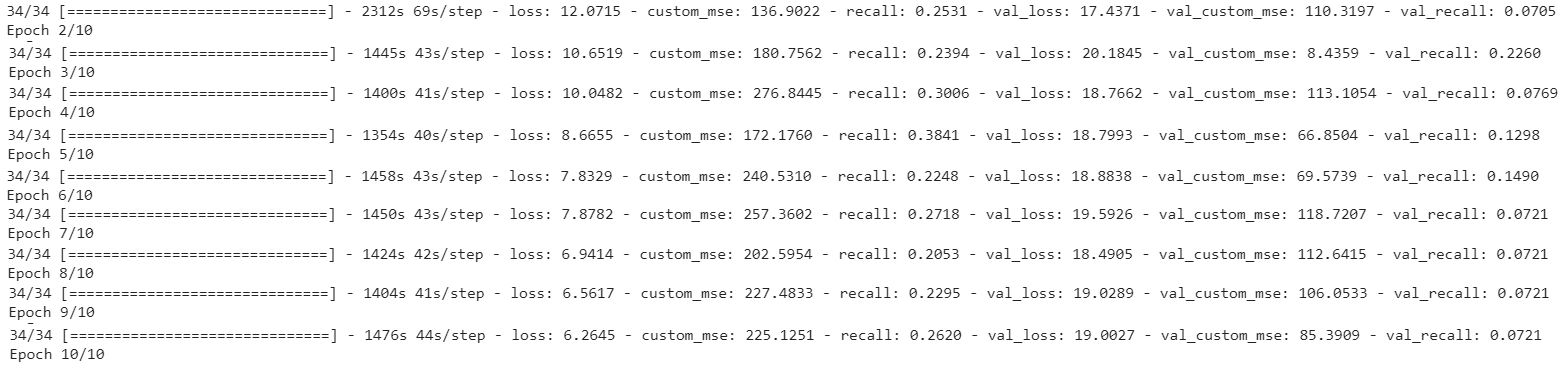

## training with loss, modified mse, recall

In [ ]:
# Modify mse metric: only calculate dist between confident scores > 0.5
history_modified_mse_metric = run_experiment(vit_resnet_backbone_model,history_= 'use_generator')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
 6
y true class = 
 [[0 0 nan ... nan nan nan]
 [0 0 nan ... nan nan nan]
 [0 0 nan ... nan nan nan]
 [0 0 nan ... nan nan nan]
 [0 0 nan ... nan nan nan]]
y pred class = 
 [[0.492466152 0.861984849 0.825798094 ... 0.969612718 0.962777197 8.20878486e-05]
 [0.688673258 0.633979559 0.236955732 ... 0.991401553 0.859568357 0.000533849]
 [0.550403297 0.959114194 0.445172548 ... 0.969572544 0.92289412 0.000226169825]
 [0.80535 0.791642427 0.947777033 ... 0.996895969 0.997538447 7.44925228e-06]
 [0.635962188 0.843631804 0.806946516 ... 0.998679698 0.962911606 3.27010434e-06]]
indices from hungarian algorithm is larger than the object
col = 
 6
row = 
 0
y true class = 
 [[0 0 nan ... nan nan nan]
 [0 0 nan ... nan nan nan]
 [0 0 nan ... nan nan nan]
 [0 0 nan ... nan nan nan]
 [0 0 nan ... nan nan nan]]
y pred class = 
 [[0.492466152 0.861984849 0.825798094 ... 0.969612718 0.962777197 8.20878486e-05]
 [0.688673258 0.633979559 0.23695573

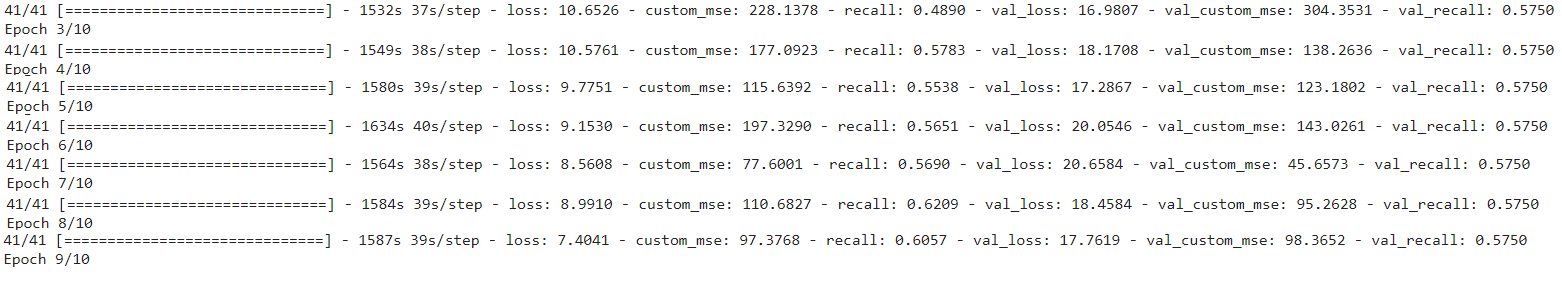

## training using recall in callback

Reason why: There is a problem with computing precision and recall using keras.metrics and keras.losses API. Remember - that the final value of loss or metric is a mean across every batch - but for precision` and recall - a mean across the batches is not equal to the final metric value. I advise you to use keras.callbacks in order to compute appropriate values.

https://stackoverflow.com/questions/48742662/custom-macro-for-recall-in-keras

In [ ]:
# Using with the recall metric to avoid error tf.function-decorated function tried to create variables on non-first call.
tf.config.run_functions_eagerly(True)
history_recall_in_callback = run_experiment(vit_resnet_backbone_model,history_= 'use_generator')

In [ ]:
history_1 = run_experiment(vit_resnet_backbone_model,history_= 'use_generator')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/4

reduce_confident_loss =  0.803938866

reduce_mean_cls_loss =  0.874852777

regression loss =  111.121033
      1/Unknown - 149s 149s/step - loss: 112.7998 - custom_mse: 2395.1819
reduce_confident_loss =  0.829265654

reduce_mean_cls_loss =  0.62404573

regression loss =  54.5301132
      2/Unknown - 205s 57s/step - loss: 84.3916 - custom_mse: 2546.6406  
reduce_confident_loss =  0.769748747

reduce_mean_cls_loss =  0.699089468

regression loss =  47.2647362
      3/Unknown - 259s 55s/step - loss: 72.5056 - custom_mse: 2701.7148
reduce_confident_loss =  0.775489688

reduce_mean_cls_loss =  0.769976497

regression loss =  41.7800446
      4/Unknown - 312s 55s/step - loss: 65.2106 - custom_mse: 2779.4500
reduce_confident_loss =  0.743893087

reduce_mean_cls_loss =  0.620705247

regression loss =  39.149231
      5/Unknown - 366s 54s/step - loss: 60.2712 - custom_mse: 2825.9856
reduce_confident_loss =  0.789561629

reduce_mean_cls_loss =  0.657691061

regression loss =  36.52246

In [ ]:
vit_resnet_backbone_model.save("/content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/save_model/vit_resnet_hungrian_bce_loss_1")

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/save_model/vit_resnet_hungrian_bce_loss_1/assets


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/save_model/vit_resnet_hungrian_bce_loss_1/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
history_2 = run_experiment(vit_resnet_backbone_model,history_= 'use_generator')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.

reduce_mean_cls_loss =  0.315029293

regression loss =  6.49456644

reduce_confident_loss =  0.785332859

reduce_mean_cls_loss =  0.314976901

regression loss =  5.18259907

reduce_confident_loss =  0.785292506

reduce_mean_cls_loss =  0.314655155

regression loss =  7.91458941

reduce_confident_loss =  0.785356402

reduce_mean_cls_loss =  0.315101892

regression loss =  13.0387039

reduce_confident_loss =  0.785395324

reduce_mean_cls_loss =  0.740825236

regression loss =  68.3882294
73/73 [==============================] - 865s 12s/step - loss: 48.6335 - custom_mse: 218912.6250 - val_loss: 18.8952 - val_custom_mse: 22479.0469
Epoch 3/15

reduce_confident_loss =  0.776610553

reduce_mean_cls_loss =  1.11907709

regression loss =  101.015701
 1/73 [..............................] - ETA: 32:36 - loss: 102.9114 - custom_mse: 3806.4944
reduce_confident_loss =  0.78212589

reduce_mean_cls_loss =  0.656089246

regression loss =  44.

In [ ]:
# Test with nan values in validation = 0. I forgot to change it
history_2 = run_experiment(vit_resnet_backbone_model,history_= 'use_generator')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.

reduce_mean_cls_loss =  0.620021284

regression loss =  7.74074173
21/41 [==============>...............] - ETA: 9:11 - loss: 12.1025 - custom_mse: 262.5145
reduce_confident_loss =  0.794042885

reduce_mean_cls_loss =  0.698834121

regression loss =  8.18835926
22/41 [===============>..............] - ETA: 8:42 - loss: 11.9925 - custom_mse: 283.5906
reduce_confident_loss =  0.676486909

reduce_mean_cls_loss =  0.689739227

regression loss =  8.12380219
23/41 [===============>..............] - ETA: 8:14 - loss: 11.8837 - custom_mse: 121.5944
reduce_confident_loss =  0.938977778

reduce_mean_cls_loss =  0.693138182

regression loss =  6.0613184
24/41 [================>.............] - ETA: 7:46 - loss: 11.7091 - custom_mse: 64.1711 
reduce_confident_loss =  0.937685132

reduce_mean_cls_loss =  0.693146527

regression loss =  5.64422226
25/41 [=================>............] - ETA: 7:18 - loss: 11.5317 - custom_mse: 85.8029
reduce_

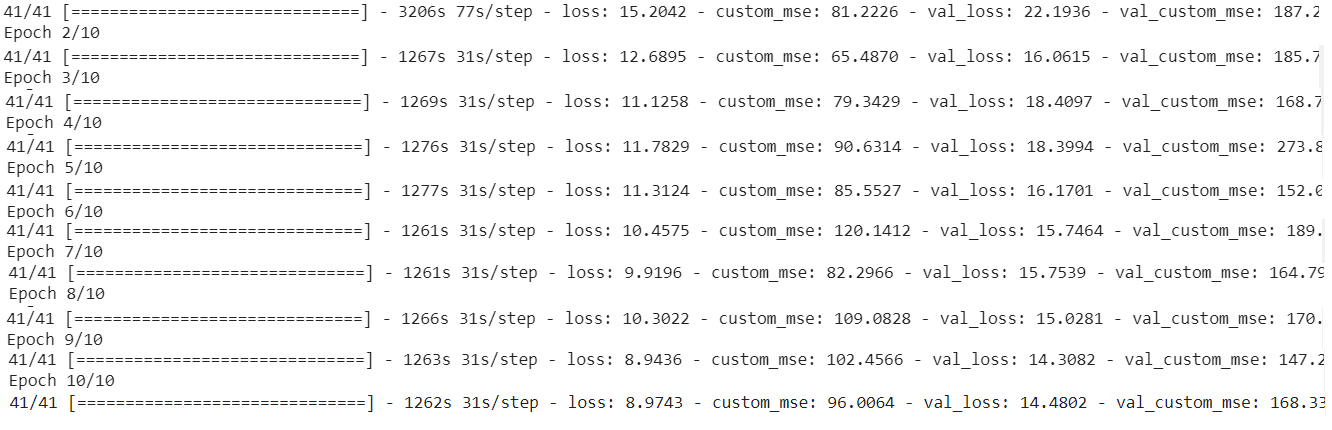

In [ ]:
vit_resnet_backbone_model.save("/content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/save_model/vit_resnet_hungrian_bce_loss_2")

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/save_model/vit_resnet_hungrian_bce_loss_2/assets


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/save_model/vit_resnet_hungrian_bce_loss_2/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
vit_resnet_backbone_model.save("/content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/save_model/vit_resnet_hungrian_bce_loss_3.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# Test 

In [ ]:
num_of_image = '006484'
round = 'round1'

In [ ]:
def show_prediction(num_of_image,round):
    # RGB image
    test_predict_img_front_path = f'/content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town01/rgb_image/front_image/{round}/{round}_{num_of_image}.jpg'
    test_predict_img_left_path = f'/content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town01/rgb_image/left_image/{round}/{round}_{num_of_image}.jpg'
    test_predict_img_right_path = f'/content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town01/rgb_image/right_image/{round}/{round}_{num_of_image}.jpg'
    test_predict_img_back_path = f'/content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town01/rgb_image/back_image/{round}/{round}_{num_of_image}.jpg'

    test_predict_img_front = read_rgb_image(test_predict_img_path)
    test_predict_img_left = read_rgb_image(test_predict_img_left_path)
    test_predict_img_right = read_rgb_image(test_predict_img_right_path)
    test_predict_img_back = read_rgb_image(test_predict_img_back_path)

    # Depth image
    test_predict_img_front_depth_path = f'/content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town01/depth_image/front_image/{round}/{round}_{num_of_image}.png'
    test_predict_img_left_depth_path = f'/content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town01/depth_image/left_image/{round}/{round}_{num_of_image}.png'
    test_predict_img_righ_depth_path = f'/content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town01/depth_image/right_image/{round}/{round}_{num_of_image}.png'
    test_predict_img_back_depth_path = f'/content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town01/depth_image/back_image/{round}/{round}_{num_of_image}.png'

    test_predict_img_depth_front = read_depth_image(test_predict_img_front_depth_path)
    test_predict_img_depth_left = read_depth_image(test_predict_img_left_depth_path)
    test_predict_img_depth_right = read_depth_image(test_predict_img_righ_depth_path)
    test_predict_img_depth_back = read_depth_image(test_predict_img_back_depth_path)

    # Concatenate rgb and depth
    concatennate_rgb_depth_front = tf.concat([test_predict_img_front,test_predict_img_depth_front],axis=-1)
    concatennate_rgb_depth_right = tf.concat([test_predict_img_right,test_predict_img_depth_left],axis=-1)
    concatennate_rgb_depth_left = tf.concat([test_predict_img_left,test_predict_img_depth_left],axis=-1)
    concatennate_rgb_depth_back = tf.concat([test_predict_img_back,test_predict_img_depth_back],axis=-1)

    normalized_front = normalize_on_rgb_depth(concatennate_rgb_depth_front)
    normalized_left = normalize_on_rgb_depth(concatennate_rgb_depth_left)
    normalized_right = normalize_on_rgb_depth(concatennate_rgb_depth_right)
    normalized_back = normalize_on_rgb_depth(concatennate_rgb_depth_back)


    normalized_front_expand = tf.expand_dims(normalized_front,axis=0)
    normalized_left_expand = tf.expand_dims(normalized_left,axis=0)
    normalized_right_expand = tf.expand_dims(normalized_right,axis=0)
    normalized_back_expand = tf.expand_dims(normalized_back,axis=0)

    concat_all_sides = tf.concat([normalized_front_expand,normalized_left_expand,normalized_right_expand,normalized_back_expand],axis=0)    
    concat_all_sides = tf.expand_dims(concat_all_sides,axis = 0)

    # Run prediction
    prediction = vit_resnet_backbone_model.predict(concat_all_sides)
    plt.imshow(cv2.imread(test_predict_img_front_path))
    tf.print(prediction.reshape((7,4)))

array([[-18.339245  ,  -7.079572  , -17.967066  ,  14.553135  ],
       [ 17.6661    ,  -9.033151  ,  -4.478234  ,   1.3453833 ],
       [ -7.056542  ,  15.691201  , -14.380486  ,  -1.5405031 ],
       [ 21.184322  ,  14.703356  ,   1.0204788 ,  -4.4348283 ],
       [ 23.613546  ,   5.1092587 ,  -5.324966  ,  -4.4120116 ],
       [ 26.839258  , -11.163725  ,  -1.2937788 ,  -2.724493  ],
       [-22.615032  ,  -0.12604015,  17.059353  ,  -9.124053  ]],
      dtype=float32)


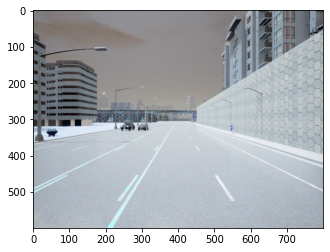

In [ ]:
show_prediction(num_of_image,round)

RGB images

In [ ]:
test_predict_img_front_path = f'/content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town01/rgb_image/front_image/round3/round3_{num_of_image}.jpg'
test_predict_img_left_path = f'/content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town01/rgb_image/left_image/round3/round3_{num_of_image}.jpg'
test_predict_img_right_path = f'/content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town01/rgb_image/right_image/round3/round3_{num_of_image}.jpg'
test_predict_img_back_path = f'/content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town01/rgb_image/back_image/round3/round3_{num_of_image}.jpg'

test_predict_img_front = read_rgb_image(test_predict_img_path)
test_predict_img_left = read_rgb_image(test_predict_img_left_path)
test_predict_img_right = read_rgb_image(test_predict_img_right_path)
test_predict_img_back = read_rgb_image(test_predict_img_back_path)

Depth images

In [ ]:
test_predict_img_front_depth_path = f'/content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town01/depth_image/front_image/round3/round3_{num_of_image}.png'
test_predict_img_left_depth_path = f'/content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town01/depth_image/left_image/round3/round3_{num_of_image}.png'
test_predict_img_righ_depth_path = f'/content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town01/depth_image/right_image/round3/round3_{num_of_image}.png'
test_predict_img_back_depth_path = f'/content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town01/depth_image/back_image/round3/round3_{num_of_image}.png'

test_predict_img_depth_front = read_depth_image(test_predict_img_front_depth_path)
test_predict_img_depth_left = read_depth_image(test_predict_img_left_depth_path)
test_predict_img_depth_right = read_depth_image(test_predict_img_righ_depth_path)
test_predict_img_depth_back = read_depth_image(test_predict_img_back_depth_path)

Concatenate

In [ ]:
# Concatenate rgb and depth
concatennate_rgb_depth_front = tf.concat([test_predict_img_front,test_predict_img_depth_front],axis=-1)
concatennate_rgb_depth_right = tf.concat([test_predict_img_right,test_predict_img_depth_left],axis=-1)
concatennate_rgb_depth_left = tf.concat([test_predict_img_left,test_predict_img_depth_left],axis=-1)
concatennate_rgb_depth_back = tf.concat([test_predict_img_back,test_predict_img_depth_back],axis=-1)

normalized_front = normalize_on_rgb_depth(concatennate_rgb_depth_front)
normalized_left = normalize_on_rgb_depth(concatennate_rgb_depth_left)
normalized_right = normalize_on_rgb_depth(concatennate_rgb_depth_right)
normalized_back = normalize_on_rgb_depth(concatennate_rgb_depth_back)

In [ ]:
normalized_front_expand = tf.expand_dims(normalized_front,axis=0)
normalized_left_expand = tf.expand_dims(normalized_left,axis=0)
normalized_right_expand = tf.expand_dims(normalized_right,axis=0)
normalized_back_expand = tf.expand_dims(normalized_back,axis=0)

In [ ]:
normalized_back_expand.shape

TensorShape([1, 200, 200, 4])

In [ ]:
concat_all_sides = tf.concat([normalized_front_expand,normalized_left_expand,normalized_right_expand,normalized_back_expand],axis=0)

In [ ]:
concat_all_sides = tf.expand_dims(concat_all_sides,axis = 0)

In [ ]:
concat_all_sides.shape

TensorShape([1, 4, 200, 200, 4])

In [ ]:
vit_resnet_backbone_model.predict(concat_all_sides)

array([[-1.26018267e+01, -6.47885036e+00, -1.45323305e+01,
         1.15185947e+01,  1.71507587e+01, -5.59835243e+00,
        -4.12346077e+00,  2.24878624e-01, -7.08493710e+00,
         1.01386576e+01, -1.02705517e+01, -3.74427706e-01,
         1.68265953e+01,  1.49047499e+01,  2.31250000e+00,
        -1.77779830e+00,  1.73440380e+01,  4.46030903e+00,
        -3.55648065e+00, -1.58945751e+00,  2.42900105e+01,
        -9.68129921e+00,  2.07253844e-02, -2.28077722e+00,
        -1.57672348e+01, -2.07410240e+00,  1.28771639e+01,
        -7.75781918e+00]], dtype=float32)

# load model

In [ ]:
path_to_model = "/content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/save_model/vit_resnet_hungrian_bce_loss_2"
custom_objects = {'Patches':Patches,'PatchEncoder': PatchEncoder, # Still have a problem here
                  'Hungarian_loss': hungarian_loss,
                  'custom_MSE': custom_MSE,
                  'hungarian_loss_fit':hungarian_loss_fit }
reconstructed_model = tf.keras.models.load_model(path_to_model,custom_objects=custom_objects)                                                                                                                                                     

In [ ]:
reconstructed_model.predict(concat_all_sides)

array([[-1.26018267e+01, -6.47885036e+00, -1.45323305e+01,
         1.15185947e+01,  1.71507587e+01, -5.59835243e+00,
        -4.12346077e+00,  2.24878624e-01, -7.08493710e+00,
         1.01386576e+01, -1.02705517e+01, -3.74427706e-01,
         1.68265953e+01,  1.49047499e+01,  2.31250000e+00,
        -1.77779830e+00,  1.73440380e+01,  4.46030903e+00,
        -3.55648065e+00, -1.58945751e+00,  2.42900105e+01,
        -9.68129921e+00,  2.07253844e-02, -2.28077722e+00,
        -1.57672348e+01, -2.07410240e+00,  1.28771639e+01,
        -7.75781918e+00]], dtype=float32)